In [43]:
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=130264 sha256=3d4b39b643963edeaebe05cccdcc0856ee7bbe909640345ce543feea7cf0a06b
  Stored in directory: /home/nikita/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pydub
import librosa
import nemo.collections.asr as nemo_asr
import glob
import nemo.collections.tts as nemo_tts
import numpy as np
import torch
import pyctcdecode
from word_beam_search import WordBeamSearch
from ctcdecode import CTCBeamDecoder
import itertools
import symspellpy
import matplotlib.pyplot as plt

[NeMo W 2022-12-14 17:57:09 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-14 17:57:10 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-14 17:57:10 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-14 17:57:10 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [30]:
models = [
    #'stt_en_quartznet15x5',
    'QuartzNet15x5Base-En'
]
#for model in models:
asr = nemo_asr.models.EncDecCTCModel.from_pretrained(models[0], strict=False).eval().cpu()
config =asr.to_config_dict()
labels = config['decoder']['vocabulary'] + ['']
decoder = pyctcdecode.build_ctcdecoder(labels, "text.arpa", alpha=0.5, beta=1.5)

sm = symspellpy.SymSpell(max_dictionary_edit_distance=2)
sm.create_dictionary(corpus="train_text.txt")

[NeMo I 2022-12-14 18:09:06 cloud:56] Found existing object /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-12-14 18:09:06 cloud:62] Re-using file from: /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-12-14 18:09:06 common:911] Instantiating model from pre-trained checkpoint
[NeMo I 2022-12-14 18:09:07 features:225] PADDING: 16
[NeMo I 2022-12-14 18:09:07 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /home/nikita/.cache/torch/NeMo/NeMo_1.13.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Only 37 unigrams passed as vocabulary. Is this small or artificial data?
Loading the LM will be faster if you build a binary file.
Reading /home/nikita/Documents/denti/text.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


True

In [32]:
for f in glob.glob("test/*.wav"):
    seg = pydub.AudioSegment.from_file(f)
    samples = seg.get_array_of_samples()
    samples = np.array(samples).astype(np.float32)
    lengths = torch.IntTensor([len(samples)]).to('cpu')
    samples = torch.FloatTensor(samples.reshape(1,-1)).to('cpu')
    with torch.no_grad():
        logs,_,tops = asr.forward(input_signal=samples, input_signal_length=lengths)


    #''.join([labels[int(ind)] for ind in tops.numpy()[0]])

    transcript = [labels[int(k)] for (k, g) in itertools.groupby(tops[0].numpy())]
    baseline_text = ''.join(transcript)
    print(baseline_text)
    print(decoder.decode(logs[0].numpy()))
    decoded_text = decoder.decode(logs[0].numpy(), hotwords=['mesial', 'light', 'margin', 'gingival'], hotword_weight=10)
    print(decoded_text)
    final_text = [sm.lookup_compound(w, 2)[0].term if len(sm.lookup(w.lower(), 2)) else w for w in decoded_text.split()]
    print(final_text)

frocation eighteen grade one
furcation eighteen grade one
furcation eighteen grade one
['furcation', 'eighteen', 'grade', 'one']
jamp ginger ol mardarin
jump gingerol margarin
jump gingerol margrin
['jump', 'gingerol', 'margin']
flack white on all
plaque white on all
plaque white on all
['plaque', 'white', 'one', 'all']
leading thirteen mesialingual
bleeding thirteen mesialingual
bleeding thirteen mesial ligual
['bleeding', 'thirteen', 'mesial', 'ligual']


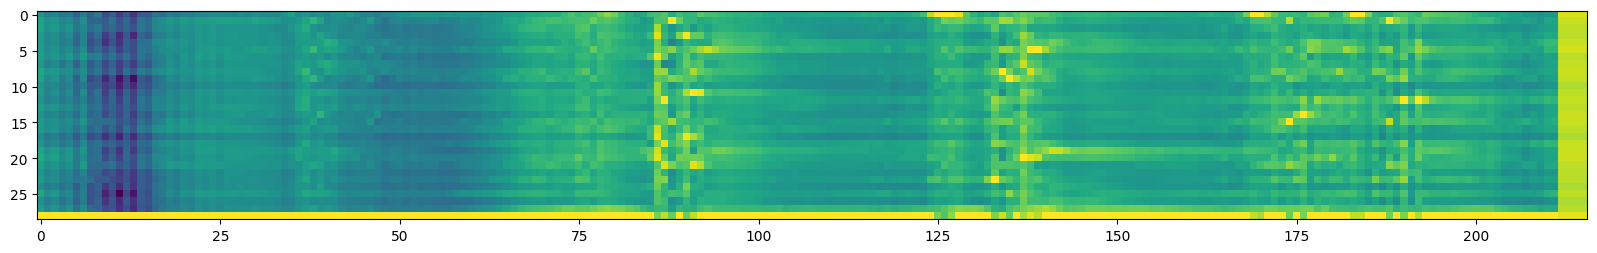

In [18]:
plt.figure(figsize=(20,8))
plt.imshow(logs[0].T)
plt.show()